<a href="https://colab.research.google.com/github/KuanWeiBeCool/Object-Extraction-From-Images/blob/main/Object_Extraction_From_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from skimage import measure
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Original MNIST Digits:

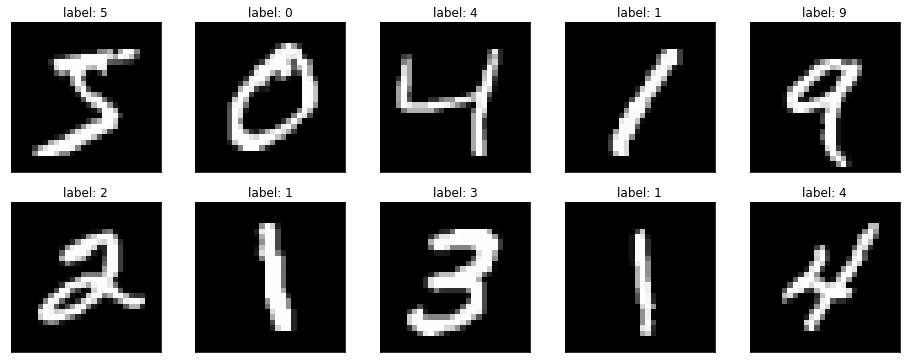

In [3]:
i = 0
fig = plt.figure(figsize=(16,16))
for i in range(10):
  ax = fig.add_subplot(5, 5, i+1)
  ax.imshow(x_train[i, :, :], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title("label: {}".format(y_train[i]))  
plt.show()

# Skimage extraction
In this section, I will use MNIST Handwritten digit to demonstrate how to extract objects from images.

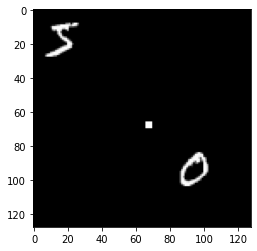

In [14]:
test_sample = np.zeros((128, 128))
# Insert image
first_digit = x_train[0]
second_digit = x_train[1]
test_sample[3:31, 3:31] = first_digit
test_sample[80:108, 80:108] = second_digit
test_sample[66:70, 66:70] = 256
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_sample, cmap='gray')
plt.show()

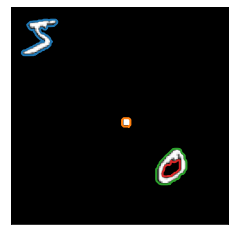

In [16]:
from skimage import measure
# Find contours at a constant value of 10
contours = measure.find_contours(array=test_sample, level=10)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(test_sample, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

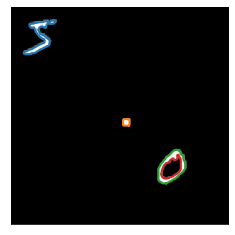

In [7]:
# Find contours at a constant value of 150
contours = measure.find_contours(test_sample, 150)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(test_sample, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [12]:
contours[0][:10]

array([[27.29245283, 11.        ],
       [27.40711462, 10.        ],
       [27.40711462,  9.        ],
       [27.40711462,  8.        ],
       [27.        ,  7.11965812],
       [26.        ,  7.81196581],
       [25.87209302,  8.        ],
       [25.63461538,  9.        ],
       [25.        ,  9.8627451 ],
       [24.87719298, 10.        ]])

The values of contours represent the axis values: contour[:, 1] represents the horizontal axis, and contour[:, 0] represents the vertical axis. Notice that the contour values are not integers. This is because it tries to find the "level" value in your pixel array. However, you may not have values exactly equal to the "level" value. For example, if your level value is 10, and two values at (1, 1) and (1, 2) are 0 and 20 respectively, then the position of the contour between these two points will be (1, 1.5). 

Since the values of contours represent the axis values, we can utilize them to crop our image and obtain the object we want. Specifically, the object must contain between max(contour[0]) and min(contour[0]), and between max(contour[1]) and min(contour[1]).

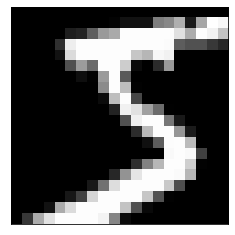

In [ ]:
first_contour = contours[0].astype(int)
start_row = min(first_contour[:, 0])
end_row = max(first_contour[:, 0])
start_col = min(first_contour[:, 1])
end_col = max(first_contour[:, 1])

fig, ax = plt.subplots()
ax.imshow(test_sample[start_row:end_row, start_col:end_col], cmap=plt.cm.gray)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Now that we extracted our first image successfully! However, for "0", we can notice that there are two contours: the larger contour in orange contains the entire "0" digit, but the smaller contour in green contains the inside part, which is not what we want. Thus, as we know that only two objects need to be extracted, we can choose the two longest contours.

In [ ]:
contours_lengths = []
contours_selected = []
num_objects = 2
# Obtain the indices for the largest contours
for contour in contours:
  contours_lengths.append(len(contour))
  indices_largest_contours = np.array(contours_lengths).argsort()[-num_objects:][::-1]
# Fill the largest contours into a new list
for index in indices_largest_contours:
  contours_selected.append(contours[index])


2

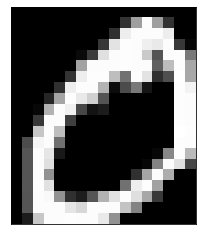

In [ ]:
# Obtain number "0"
second_contour = contours_selected[1].astype(int)
start_row = min(second_contour[:, 0])
end_row = max(second_contour[:, 0])
start_col = min(second_contour[:, 1])
end_col = max(second_contour[:, 1])

fig, ax = plt.subplots()
ax.imshow(test_sample[start_row:end_row, start_col:end_col], cmap=plt.cm.gray)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Sometimes, images may be too sharp and if we directly use the image to find contours, we may find many contours that contain small objects of the image. In situations like this, we will need to smoothen the image:

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

4423680/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


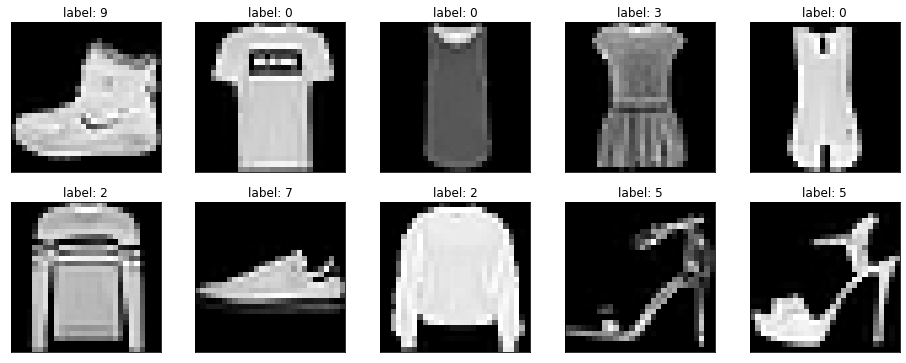

In [4]:
i = 0
fig = plt.figure(figsize=(16,16))
for i in range(10):
  ax = fig.add_subplot(5, 5, i+1)
  ax.imshow(x_train[i, :, :], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title("label: {}".format(y_train[i]))  
plt.show()

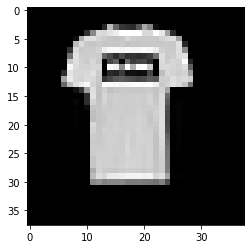

In [5]:
test_sample = np.zeros((38, 38))
# Insert image
first_digit = x_train[1]
test_sample[3:31, 3:31] = first_digit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_sample, cmap='gray')
plt.show()

Too many contours are detected:

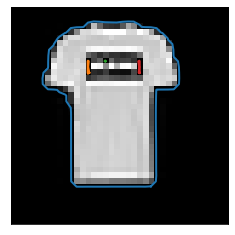

In [8]:
# Find contours at a constant value of 150
contours = measure.find_contours(test_sample, 10)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(test_sample, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

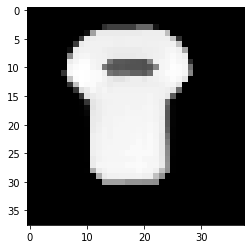

In [9]:
from skimage import filters
test_sample_smoothed = filters.median(test_sample, selem=np.ones((5, 5)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_sample_smoothed, cmap='gray')
plt.show()

After smoothen, only one contour is detected:

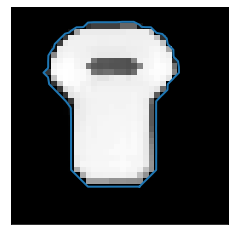

In [11]:
# Find contours at a constant value of 150
contours = measure.find_contours(test_sample_smoothed, 10)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(test_sample_smoothed, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()